# **Exercise 5**: Model scenario analysis

In this exercises we will do a scenario analysis with the model created with notebook 01.
We will update the sea level boundary condition to simulate the effect of sea level rise on flood risk in Savannah.
You can use this notebook as template to run other scenario analyses to e.g. assess the effect of adaptation measures, land use changes, or future climate conditions.

The steps to do so are:
- Step 1: Read the model a change the output root folder to a new directory
- Step 2: Update the model and save it. This can be the sea level boundary condition, or any other model parameter you want to change.
- Step 3: Run the model again
- Step 4: Inspect the differences in the results (flood extent, flood depth, etc.)

## **Step 0:** Import dependencies

Before anything else we need to import the required packages

In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import hydromt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

# local script
from sfincs_utils import run_sfincs

## **Step 1:** Read the model a change the output root
Now let's copy our old model to a new folder, so we can always look at the old model later on:

In [2]:
model_root_old = '..\models\sfincs_savannah'
model_root_new = '..\models\sfincs_savannah_slr_weir'

# initialize the old model again with a logger and the data catalog
# but now in read-only mode
logger = setuplog("SFINCS_log_savannah", log_level=20)
sf = SfincsModel(root=model_root_old, mode="r", logger=logger)
sf.read()

# change the model root (to not overwrite existing model)
# it is recommended to use a different root_folder for each model run
# make sure to keep your folders well organized
# NOTE that this does not copy any data, it just points to a new location where the model will be saved later
sf.set_root(model_root_new, mode="w+")

2026-01-27 16:07:16,796 - SFINCS_log_savannah - log - INFO - HydroMT version: 0.10.1
2026-01-27 16:07:16,818 - SFINCS_log_savannah - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.2.1).
2026-01-27 16:07:16,829 - SFINCS_log_savannah - sfincs - WARNING - depfile not found at c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah\sfincs.dep
2026-01-27 16:07:24,022 - SFINCS_log_savannah - sfincs - WARNING - Index in bndfile does not match c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah\gis\bnd.geojson
2026-01-27 16:07:24,030 - SFINCS_log_savannah - sfincs - WARNING - Index in bndfile does not match c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah\gis\bnd.geojson
2026-01-27 16:07:24,034 - SFINCS_log_savannah - sfincs - INFO - Model read


## **Step 2:** Update forcing

Now we will update the forcing of the model. We will use the same forcing as in the previous exercise, but will now add an offset to the water levels to simulate sea level rise.

Note that the index attribute of the locations matches with the column names of the timeseries file. This is important for HydroMT to know which timeseries belongs to which location!

In [3]:
# read  location
locations = gpd.read_file(
    Path(r"../data/gtsm_codec_reanalysis_hourly_v1/gauging_location.geojson")
)
locations

,id,geometry
0,8670870,POINT (-80.9046 32.035)
1,8720218,POINT (-81.42833 30.3983)


In [4]:
# read design hydrographs
timeseries = pd.read_csv(
    Path(r"../data/gtsm_codec_reanalysis_hourly_v1/validationtimeseries.csv"),
    index_col=0,
    parse_dates=True,
)
# clip to model event period
tstart, tstop = sf.get_model_time()
timeseries = timeseries.loc[tstart:tstop]
timeseries.iloc[[0, 1, -2, -1], :]

,8670870
date and time,
2016-10-07 00:00:00,-0.079248
2016-10-07 01:00:00,0.219456
2016-10-12 22:00:00,1.496568
2016-10-12 23:00:00,1.414272


In [5]:
# estimate the sea level rise in 2100
# hint use the IPCC AR6 interactive atlas via https://interactive-atlas.ipcc.ch/regional-information
# select the right variable, period en scenario, then click on the region of interest to get the a graph or table from which you can estimate the sea level rise
slr = 1 # [m] FILL IN YOUR ESTIMATE HERE

timeseries_slr = timeseries.copy()
# change the event period to 2100
timeseries_slr.index = (
    timeseries.index - timeseries.index[0] + pd.Timestamp("2100-01-01")
)
# add sea level rise to the timeseries
timeseries_slr = timeseries_slr + slr

2026-01-27 16:07:28,457 - SFINCS_log_savannah - sfincs - INFO - Setting gdf_locs index to id
2026-01-27 16:07:28,465 - SFINCS_log_savannah - model_api - WARNING - Replacing forcing: bzs
2026-01-27 16:07:28,954 - SFINCS_log_savannah - data_catalog - INFO - Reading data catalog artifact_data latest
2026-01-27 16:07:28,955 - SFINCS_log_savannah - data_catalog - INFO - Parsing data catalog from C:\Users\sanne\.hydromt_data\artifact_data\v0.0.9\data_catalog.yml
2026-01-27 16:07:29,462 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ../data_processed/weir.geojson


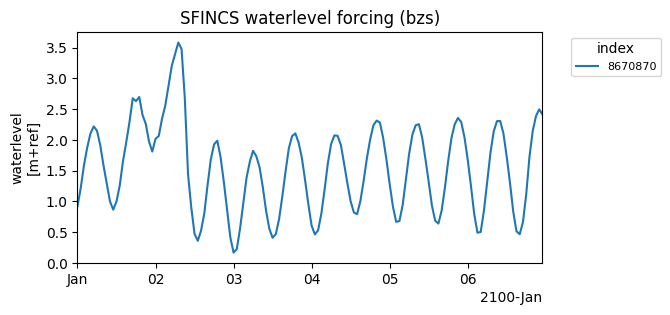

In [6]:
# we need to update the model event time to the new period
# which we can do based on the timeseries index
sf.setup_config(
    tref=timeseries_slr.index[0].to_pydatetime(),
    tstart=timeseries_slr.index[0].to_pydatetime(),
    tstop=timeseries_slr.index[-1].to_pydatetime(),
)

# this time we provide the locations and timeseries as
# pandas / geopandas objects instead of the data catalog keys
sf.setup_waterlevel_forcing(
    locations=locations,
    timeseries=timeseries_slr,
    merge=False,
    # use a large buffer to include all points if the following error is raised
    # ValueError: The gdf_locs index and df_ts columns must be the same
    buffer=1e5,  # buffer from model boundary [m]
)

sf.plot_forcing("forcing.png")

sf.setup_structures(
        structures="../data_processed/weir.geojson",
        stype='weir',
        dz=0.1,
        merge=True)

Save the model after updating the forcing.

In [7]:
# make sure to write the updated model to the new model root before running sfincs
sf.write()

2026-01-27 16:07:31,861 - SFINCS_log_savannah - sfincs - INFO - Writing model data to c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_slr_weir
2026-01-27 16:07:31,871 - SFINCS_log_savannah - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2026-01-27 16:07:34,996 - SFINCS_log_savannah - sfincs - INFO - Write geom files
2026-01-27 16:07:35,001 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2026-01-27 16:07:35,017 - SFINCS_log_savannah - sfincs - INFO - Write forcing files
2026-01-27 16:07:35,028 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2026-01-27 16:07:35,040 - SFINCS_log_savannah - sfincs - WARNING - zsini not in states, skipping


## **Step 3:** Rerun the model, using the new boundary conditions

In [8]:
# NOTE you need to download the SFINCS executable first (see first notebook) and update the path below
sfincs_exe = "../software/sfincs_v2.1.1/sfincs.exe"
run_sfincs(
    Path(sf.root, "sfincs.inp"), # path to the SFINCS model root folder
    run_method="exe", # run SFINCS using the executable, other options are "docker" or "singularity"
    sfincs_exe=sfincs_exe, # path to the sfincs executable if you want to run SFINCS on windows
)


Running SFINCS model in C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah_slr_weir with command:
>> C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\software\sfincs_v2.1.1\sfincs.exe

 -----------------------------------------

 Build-Revision: $Rev: v2.1.1-Dollerup
 Build-Date:     $Date: 2024-08-28

 Reading input file ...
 Info : Running SFINCS in subgrid mode ...
 Turning on process: Viscosity
 Advection scheme : First-order upwind
 Reading meteo data ...
 Info : Preparing SFINCS grid on regular mesh ...
 Reading index file : sfincs.ind ...
 Reading mask file : sfincs.msk ...
 Number of active z points    :       286686
 Number of active u/v points  :       571856
 Viscosity - nuvisc  =    1.000000    
 Reading sub-grid netCDF file ...
 Number of subgrid levels :           15
 Reading weir file ...
         508  structure u/v points found
 Reading water level boundaries ...
 Reading observation points ...
 Initializing output ...

 --

## **Step 4:** Inspecting the results: floodmap

Inspect the results of the updated model run by plotting the maximum water depths on a map. 
In order to do so you should first read the results of the model (*sf.read_results()*). After this you can access the results by using the results attribute: *sf.results*.
The results you can plot using matplotlib.

*Tip: Print all available result keys by typing `print(sf.results.keys())`*  
*Tip:* You can also plot the results on top of the SFINCS basemap

In [9]:
# hmax is computed by SFINCS and read-in from the sfincs_map.nc file
sf.read_results()

Text(0.5, 1.0, 'SFINCS maximum water depth')

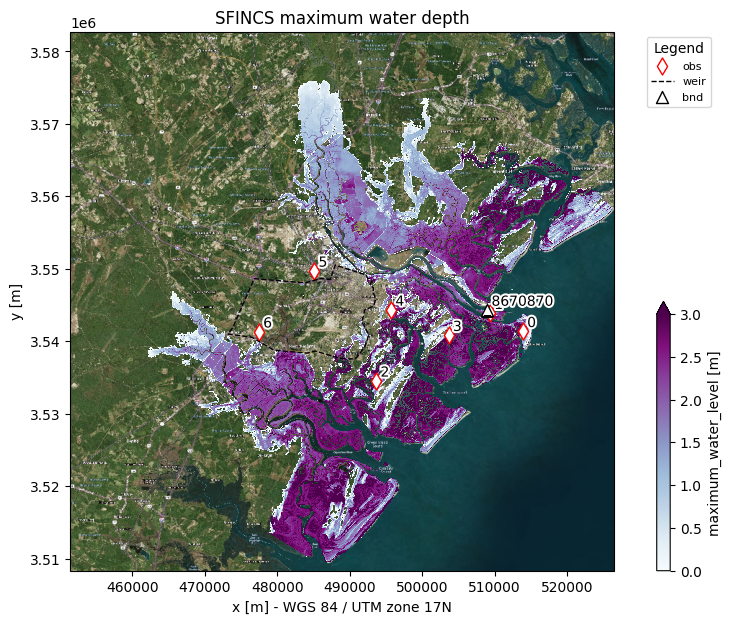

In [10]:
# We use the subgrid resolution topography to downscale the maximum water level to water depth at the subgrid resolution
# First, we read the subgrid resolution topography and check if the file exists
dep_subgrid_file = Path(model_root_old, "subgrid", "dep_subgrid.tif")  
if not dep_subgrid_file.exists():
    raise FileNotFoundError(
        f"Subgrid resolution topography file not found: {dep_subgrid_file}. "
    )
dep_subgrid = hydromt.open_raster(dep_subgrid_file, nodata=np.nan) # elevation at subgrid resolution

# calculate the maximum water depth (hmax) as the difference between 
# the maximum water level (zsmax) and the elevation (dep)
zsmax = sf.results["zsmax"].max(dim="timemax") # maximum water level
zsmax_subgrid = zsmax.raster.reproject_like(dep_subgrid, method="nearest")  # reproject to subgrid resolution
hmax_subgrid = np.maximum(0, zsmax_subgrid - dep_subgrid).round(2).astype(np.float32) # maximum water depth
# Here, we assume that all areas with a negative depth are permanent water bodies
# This is a strong simplification. It is better to use a more sophisticated approach
# to identify permanent water bodies, e.g. based on a water mask or a "tide-only" simulation.
permament_water = dep_subgrid < 0 
hmax_subgrid = hmax_subgrid.where(~permament_water, np.nan) # mask areas with permanent water
# update (geospatial) metadata
hmax_subgrid.raster.set_crs(dep_subgrid.raster.crs)
hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.name = "max water depth"
hmax_subgrid.attrs["units"] = "m"

fig, ax = sf.plot_basemap(
    fn_out="hmax.png",  # save figure to mod.root/figs/hmax.png
    variable=hmax_subgrid,
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
    vmin=0,  # set minimum value for colorbar
    vmax=3,  # set maximum value for colorbar
    cmap="BuPu",
)
ax.set_title("SFINCS maximum water depth")

In [ ]:
# save the results to a geotiff file
# round to 2 decimals to reduce file size

hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.round(2).raster.to_raster(
    Path(sf.root, f"hmax_slr{int(slr*100)}.tif"),
    compress="lzw",
    overwrite=True,
    dtype="float32",
)

In [ ]:
# load the original maximum water depth and create a difference map
# adapt and complete the code below

hmax_org_file = Path(model_root_old, "hmax.tif")
hmax_org = hydromt.open_raster(hmax_org_file)

diff_map = hmax_subgrid - hmax_org
diff_map.name = "Water Level Difference"
diff_map.attrs["long_name"] = "Water Level Difference"
diff_map.attrs["units"] = "m"

min_val = diff_map.min().compute().item()
max_val = diff_map.max().compute().item()

limit = max(abs(min_val), abs(max_val))

fig, ax = sf.plot_basemap(
        variable=diff_map,
        plot_bounds=False,
        bmap="sat",      # Achtergrondkaart
        zoomlevel=12,
        figsize=(11, 7),
        vmin=-limit,       # Minimumwaarde voor de kleurenbalk (pas aan indien nodig)
        vmax=limit,        # Maximumwaarde voor de kleurenbalk
        cmap="RdBu",     # Rood (afname) naar Blauw (toename)
        # levels=20
    )
    
    # Voeg een titel toe
ax.set_title(f"Water Depth Difference Map: SLR (+{slr}m) vs. Current")

# Exercise 5b: Adaptation measure scenario analysis

Implement the same for other scenario analyses, e.g. by implementing an adaptation measure such as a levee or floodwall.

You can do this by implementing a [weir structure](https://sfincs.readthedocs.io/en/latest/input_structures.html#weirs) in the model.

This is done by drawing a line geometry file in e.g. QGIS or geojson.io of the levee/floodwall location. Each line should have a height "z" attribute value which defines the crest height. The weir can then be added to the model using the HydroMT-SFINCS method [setup_structures()](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_structures.html#hydromt_sfincs.SfincsModel.setup_structures)

We suggest you make a copy of the notebook and implement the changes there following the steps as above.